# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Phan Võ Minh Tuệ
- MSSV: 22127440
- Lớp: Toán ứng dụng và thống kê cho Công nghệ thông tin - 22CLC10

## Import các thư viện liên quan

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import os

## Helper functions

In [2]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''
    return np.array(Image.open(img_path))


def show_img(ax, img_2d, title):
    '''
    Show image

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to draw the image on.
    img_2d : numpy.ndarray
        Image (2D)
    title : str
        The title of the image.
    '''
    ax.imshow(img_2d)
    ax.axis('off')
    ax.set_title(title)

def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    '''
    Image.fromarray(img_2d).save(img_path)


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    '''
    height, width, _ = img_2d.shape
    return img_2d.reshape(height * width, -1)

def initialize_centroids(img_1d, k_clusters, init_centroids):
    '''
    Initialize centroids

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    '''
    if init_centroids == 'random':
        centroids = np.random.randint(0, 256, (k_clusters, img_1d.shape[1])).astype(float)
    elif init_centroids == 'in_pixels':
        random_indices = np.random.choice(img_1d.shape[0], k_clusters, replace=False)
        centroids = img_1d[random_indices].astype(float)
    return centroids

def assign_clusters(img_1d, centroids):
    '''
    Assign clusters to each pixel in the image

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster

    Returns
    -------
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    distances = np.sqrt(((img_1d[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)
    return labels

def update_centroids(img_1d, labels, k_clusters):
    '''
    Update centroids

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    k_clusters : int
        Number of clusters

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    '''
    centroids = np.zeros((k_clusters, img_1d.shape[1]))
    for k in range(k_clusters):
        cluster_points = img_1d[labels == k]
        if len(cluster_points) > 0:
            centroids[k] = cluster_points.mean(axis=0)
        else:
            # If a cluster has no points, reinitialize its centroid randomly
            centroids[k] = np.random.randint(0, 256, img_1d.shape[1])
    return centroids

def kmeans(img_1d, k_clusters, max_iter, init_centroids='random', batch_size = 1000, tol=1e-4):
    '''
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    '''
    centroids = initialize_centroids(img_1d, k_clusters, init_centroids)
    data_size = img_1d.shape[0]

    for i in range(max_iter):
        mini_batch = img_1d[np.random.randint(0, data_size, batch_size)]
        labels = assign_clusters(mini_batch, centroids)
        centroids = update_centroids(mini_batch, labels, k_clusters)

        if i > 0 and np.sum(np.abs(centroids - old_centroids)) <= tol:
            break
        old_centroids = centroids.copy()

    labels = assign_clusters(img_1d, centroids)

    return centroids, labels

def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''
    new_img_1d = centroids[labels].astype(np.uint8)
    return new_img_1d.reshape(img_2d_shape)

## Main FUNCTION

In [3]:
def main():
    # Input image path and read it
    img_path = str(input('Enter image path: '))
    if not os.path.exists(img_path):
        print('Image not found')
        return
    else:
        img_2d = read_img(img_path)

    # Get image name
    dir, filename = os.path.split(img_path)
    img_name = os.path.splitext(filename)[0]

    # Generate directory to save Compressed Image (if it does not exist)
    compressed_dir = os.path.join(dir, 'Compressed')
    os.makedirs(compressed_dir, exist_ok=True)

    img_result_dir = os.path.join(compressed_dir, img_name)
    os.makedirs(img_result_dir, exist_ok=True)

    # Input k_clusters
    print('Note: k_clusters means the number of color you want in compressed image. Sample input: 3 5 7')
    k_clusters = list(map(int, input('Enter the number of colors after compressing: ').split()))

    # Input output extension
    print('Supported extensions: png, jpg, pdf')
    output_ext = input('Enter output extension: ')
    if output_ext.lower() not in ['png', 'jpg', 'pdf']:
        print('Invalid extension')
        return

    # Define parameters
    max_iter = 100
    init_centroids_methods = ['random', 'in_pixels']

    for init_centroids in init_centroids_methods:
        fig, axs = plt.subplots(1, len(k_clusters) + 1, figsize=(5 * (len(k_clusters) + 1), 5))
        fig.suptitle(f'Method: {init_centroids}', fontsize=16, y=1)
        show_img(axs[0], img_2d, 'Original Image')

        for i, k in enumerate(k_clusters, start=1):
            start_time = time.time()

            # Convert image to 1D
            img_1d = convert_img_to_1d(img_2d)

            # Apply k-means
            centroids, labels = kmeans(img_1d, k, max_iter, init_centroids)

            # Generate new image
            img_2d_new = generate_2d_img(img_2d.shape, centroids, labels)

            # Save new image
            img_path = os.path.join(img_result_dir, f'{img_name}_compressed_k{k}_{init_centroids}.{output_ext}')
            save_img(img_2d_new, img_path)

            # Show compressed image
            end_time = time.time()
            time_taken = end_time - start_time
            show_img(axs[i], img_2d_new, f'k={k}, time={time_taken:.4f} seconds')

        # Show plot
        plt.show()

Enter image path: test1.jpg
Note: k_clusters means the number of color you want in compressed image. Sample input: 3 5 7
Enter the number of colors after compressing: 3 5 7
Supported extensions: png, jpg, pdf
Enter output extension: jpg


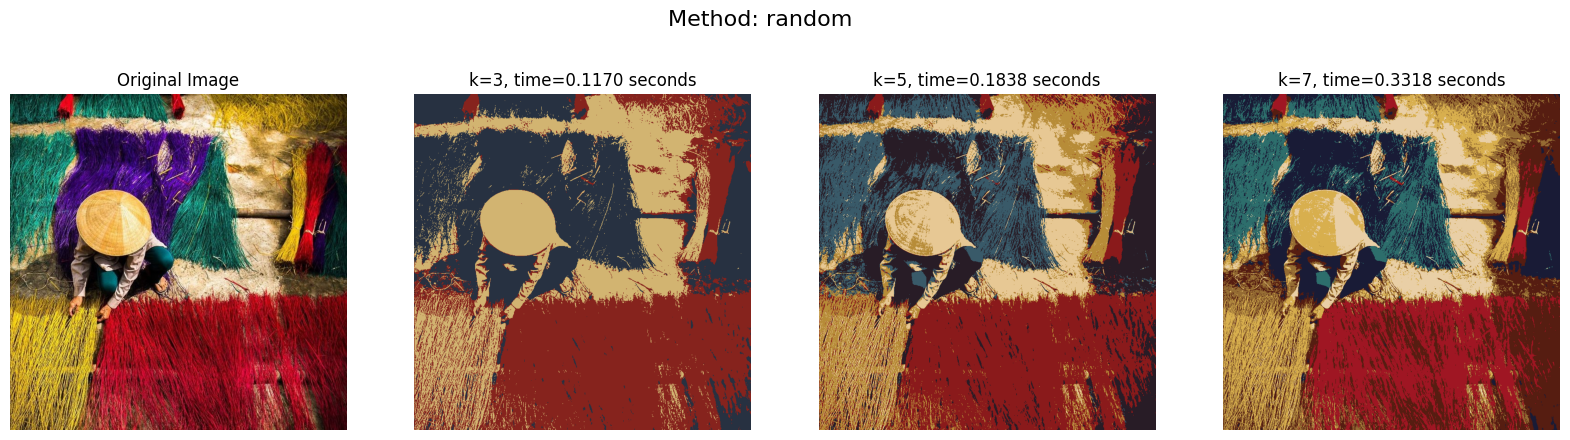

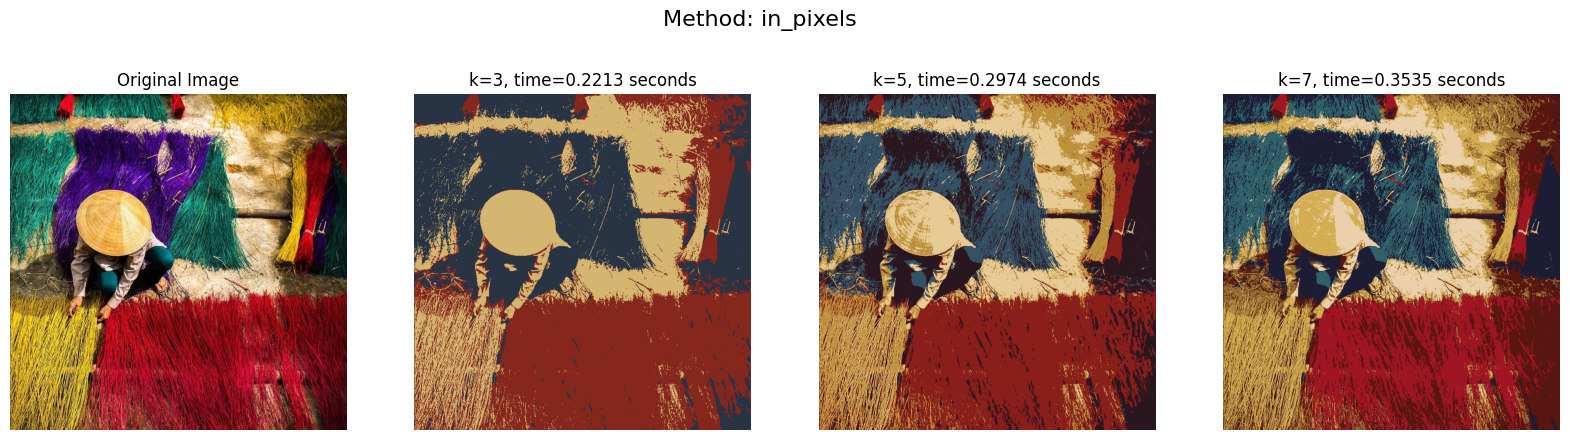

In [5]:
# Call main function
if __name__ == '__main__':
    main()